In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from IPython.display import clear_output

## Functions
### Procesess different data inputs to output standarized dataframes for different cities

In [233]:
def dataCompile(city):
    # PURPOSE: Collectes multiple CSVs together to provide formatted data
    # ARGUMENTS: city = Folder name of city data
    # RETURNS: Formatted dataframe
    
    units = {'Boston':'sec',
             'BayArea':'sec',
             'LA':'sec',
             'Philadelphia':'min',
             'Pittsburgh':'sec',
             'Portland':'sec',
             'Washington':'sec'
            }
    
    headers = {'Boston':
                   {'Duration':'tripduration',
                    'Start':'starttime'},
               'BayArea':
                   {'Duration':'duration_sec',
                    'Start':'start_time'},
               'LA':
                   {'Duration':'duration',
                    'Start':'start_time'},
               'Philadelphia':
                   {'Duration':'duration',
                    'Start':'start_time'},
               'Pittsburgh':
                   {'Duration':'Tripduration',
                    'Start':'Starttime'},
               'Portland':
                   {'Duration':'Tripduration',
                    'Start':'StartDate'},
               'Washington':
                   {'Duration':'Duration',
                    'Start':'Start date'},
              }
    
    fileDir = '../data/BikeData/' + city +'/'
    
    #Headers change between datasheets... ugh
    tripDuration = []
    startTime = []
    cityList = []
    tripList = []
    
    #Portland has odd formatting 
    if city == 'Portland':
        tripDuration = []
        for each_csv in os.listdir(fileDir):
            print(each_csv)
            df_temp = pd.read_csv(fileDir + each_csv)
            df_temp = df_temp.fillna('0')
            startDate = df_temp['StartDate'].tolist()
            startTm = df_temp['StartTime'].tolist()
            endDate = df_temp['EndDate'].tolist()
            endTm = df_temp['EndTime'].tolist()
            for i in range(len(startDate)):
                start = startDate[i] + ' ' + startTm[i]
                end = endDate[i] + ' ' + endTm[i]
                if ((start == '0 0') or (end == '0 0')):
                    continue
                else:
                    start = datetime.strptime(start, '%m/%d/%Y %H:%M')
                    end = datetime.strptime(end, '%m/%d/%Y %H:%M')
                    time_delta = (start - end)
                    #time_delta = abs(time_delta)
                    total_seconds = time_delta.total_seconds()
                    tripDuration.append(total_seconds)
                    startTime.append(startDate[i] + ' ' + startTm[i])
        
    #This handels the remander of cities
    else:
        for each_csv in os.listdir(fileDir):
            print(each_csv)
            df_temp = pd.read_csv(fileDir + each_csv)
            tripDuration.extend(df_temp[headers[city]['Duration']].tolist())
            startTime.extend(df_temp[headers[city]['Start']].tolist())
        
    cityList = []
    yearList = []
    weekList =[]
    
    print('Formatting dates')
    for date in startTime:
        try:
            dateFormatted = datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f")
        except Exception:
            try:
                dateFormatted = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
            except Exception:
                try:
                    dateFormatted = datetime.strptime(date, "%Y-%m-%d")
                except Exception:
                    try:
                        dateFormatted = datetime.strptime(date, "%m/%d/%Y %H:%M")
                    except Exception:
                        try:
                            dateFormatted = datetime.strptime(date, "%m/%d/%Y")
                        except:
                            print(f'Time formatting Error at {date}')
                                  
        yearList.append(dateFormatted.year)
        weekList.append(dateFormatted.isocalendar()[1])
        cityList.append(city)
        tripList.append(1)

    tripDuration_sec = []
    if units[city] == 'sec':
        tripDuration_sec = tripDuration
    elif units[city] == 'min':
        for time in tripDuration:
            tripDuration_sec.append(time*60)
    
    data = {'City':cityList,
            'Duration (sec)':tripDuration_sec,
            'Year':yearList,
            'Week':weekList,
            'NumTrips':tripList,
            'Date':startTime}
    
    df_data = pd.DataFrame(data)
    df_data = df_data.drop('Date', axis=1)
    
    df_data = df_data.groupby(['City',
                               'Year', 
                               'Week']).agg({'Duration (sec)':['mean'],
                                             'NumTrips':['sum']}) 
    df_data = df_data.reset_index()
    df_data.columns=['City','Year','Week','Average Duration (sec)','Number Trips']
    
    clear_output(wait=False)
    return df_data


In [157]:
def plotCityData(df):
    # PURPOSE: Plots avergae ride time and number of trips 
    # ARGUMENTS: df to plot 
    # RETURNS: none
    
    #set up x axis to plot 
    year = df['Year'].iloc[0]
    week = df['Week'].iloc[0]
    startDate = datetime.fromisocalendar(year,week,1)
    year = df['Year'].iloc[-1]
    week = df['Week'].iloc[-1]
    endDate = datetime.fromisocalendar(year,week,1)
    timeSplit = len(df)
    indexValues = pd.date_range(start=startDate, end=endDate, periods=timeSplit)
    df = df.set_index(indexValues)
    
    #plt.figure()
    #df['Average Duration (sec)'].plot()
    #df['Number Trips'].plot(secondary_y=True, style='g')
    #plt.legend(loc='best')
    #plt.figsize = (16,10)
    #plt.ylabel("Average Trip Time (sec)")
    #plt.right_ax.set_ylabel('Number Trips')
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    line1 = ax1.plot(df.index,df['Average Duration (sec)'] , 'g-', label = 'Duration')
    line2 = ax2.plot(df.index, df['Number Trips'], 'b-', label = 'Trips')
    ax1.set_ylabel('Time (sec)', fontsize = 18)
    ax2.set_ylabel('Number Trips', fontsize = 18)
    fig.set_size_inches(18, 9)
    title = df['City'].iloc[0] + ' Bike Data'
    fig.suptitle(title, fontsize=28)
    
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    leg = ax1.legend(lns, labs, loc=0, fontsize = 16)
    
    fig.show()
    

## Boston Data

In [73]:
df_Boston = dataCompile('Boston')
df_Boston

,City,Year,Week,Average Duration (sec),Number Trips
0,Boston,2015,1,627.722222,594
1,Boston,2015,2,656.997090,1718
2,Boston,2015,3,687.178298,2092
3,Boston,2015,4,539.878116,2527
4,Boston,2015,5,802.552930,1058
...,...,...,...,...,...
310,Boston,2020,49,1350.364624,22094
311,Boston,2020,50,1396.015331,23743
312,Boston,2020,51,1196.461900,11286
313,Boston,2020,52,1250.408602,10881


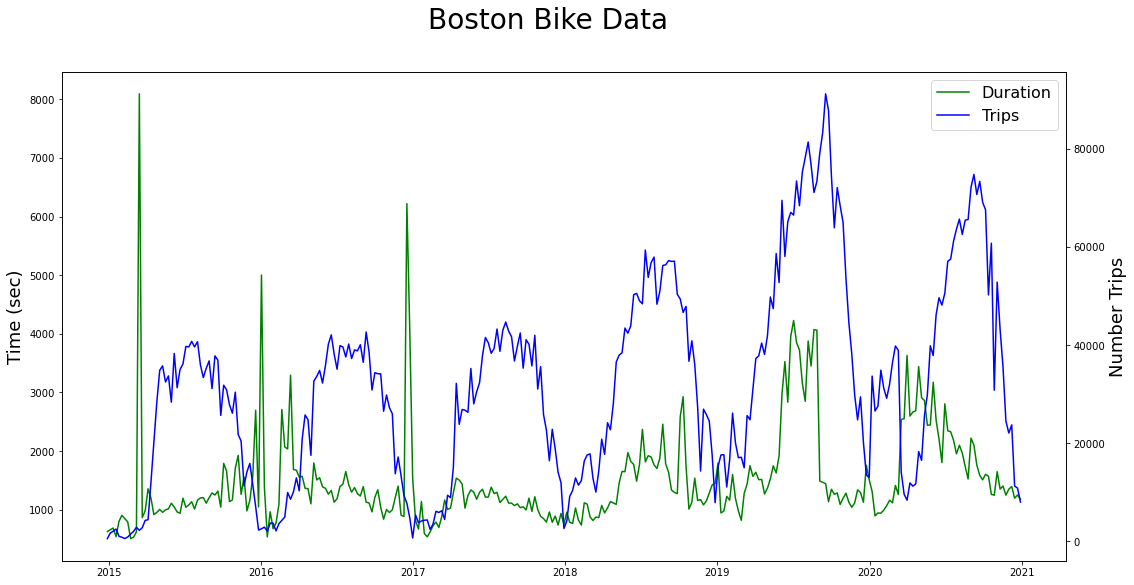

In [142]:
plotCityData(df_Boston)

## Bay Area Data

In [147]:
df_BayArea = dataCompile('BayArea')
df_BayArea

,City,Year,Week,Average Duration (sec),Number Trips
0,BayArea,2017,26,1626.756713,3687
1,BayArea,2017,27,1570.513725,5756
2,BayArea,2017,28,1516.110247,9769
3,BayArea,2017,29,1479.633111,12159
4,BayArea,2017,30,1451.768999,13251
...,...,...,...,...,...
140,BayArea,2020,10,780.385754,77018
141,BayArea,2020,11,778.556539,50169
142,BayArea,2020,12,1150.246340,19465
143,BayArea,2020,13,1075.809009,14163


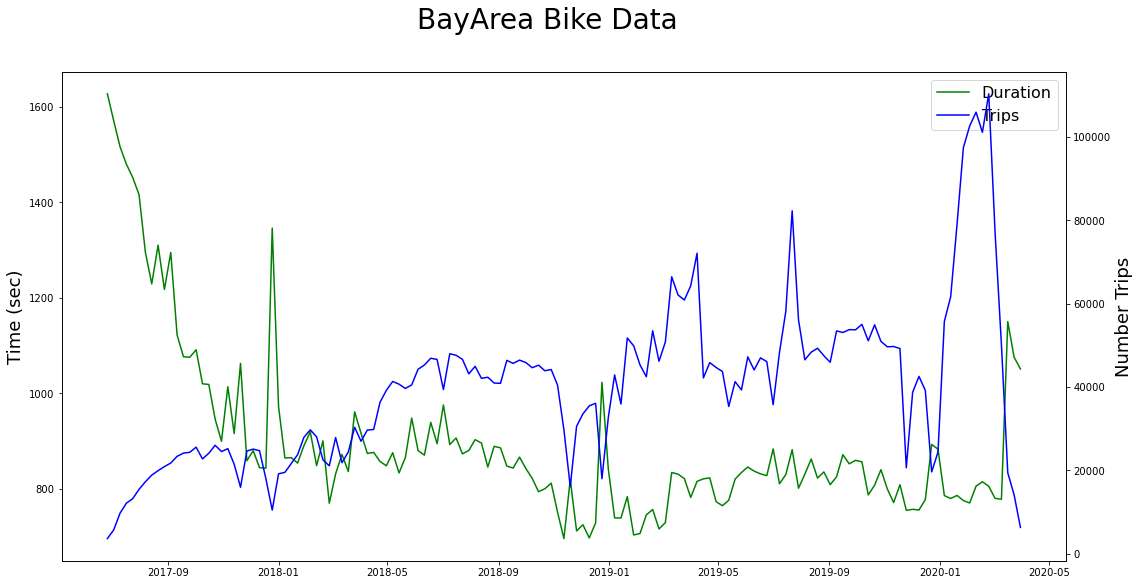

In [148]:
plotCityData(df_BayArea)

## Los Angeles Data

In [164]:
df_LA = dataCompile('LA')
df_LA

,City,Year,Week,Average Duration (sec),Number Trips
0,LA,2016,27,1534.790698,1290
1,LA,2016,28,1021.093267,3238
2,LA,2016,29,959.672657,3116
3,LA,2016,30,1159.115466,3776
4,LA,2016,31,1592.191682,5530
...,...,...,...,...,...
230,LA,2020,49,40.466348,2927
231,LA,2020,50,34.551965,3002
232,LA,2020,51,44.489150,2811
233,LA,2020,52,46.629514,2880


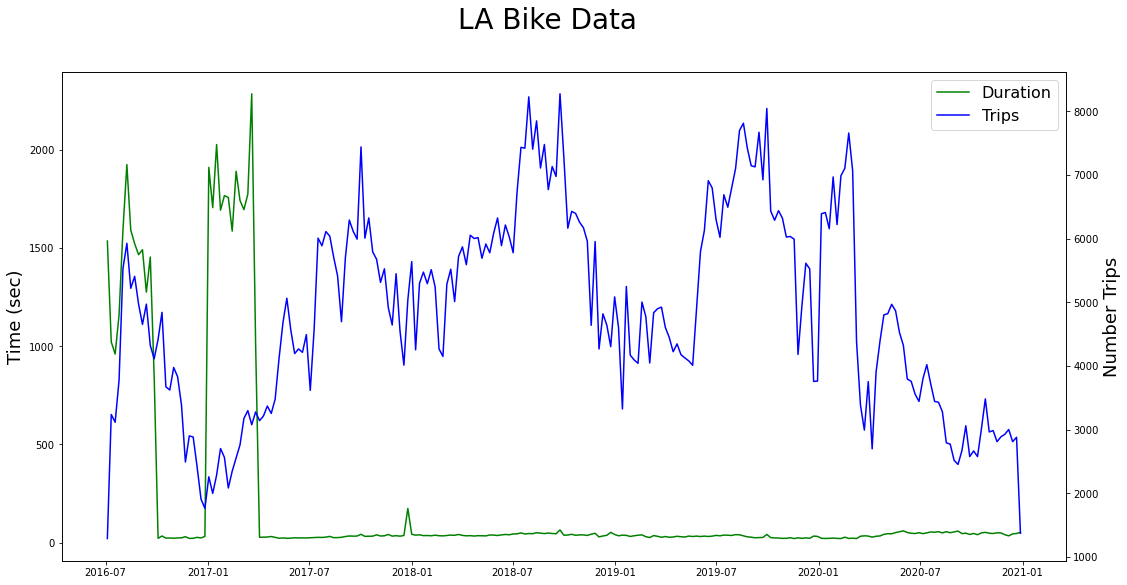

In [165]:
plotCityData(df_LA)

## Philadelphia Data

In [170]:
df_Philly = dataCompile('Philadelphia')
df_Philly

,City,Year,Week,Average Duration (sec),Number Trips
0,Philadelphia,2015,17,180036.849588,3517
1,Philadelphia,2015,18,132360.631748,11207
2,Philadelphia,2015,19,134741.028218,12935
3,Philadelphia,2015,20,119939.522790,13076
4,Philadelphia,2015,21,119936.960777,12773
...,...,...,...,...,...
294,Philadelphia,2020,49,1204.376617,7732
295,Philadelphia,2020,50,1229.620333,9482
296,Philadelphia,2020,51,1331.403250,4062
297,Philadelphia,2020,52,1183.850184,5153


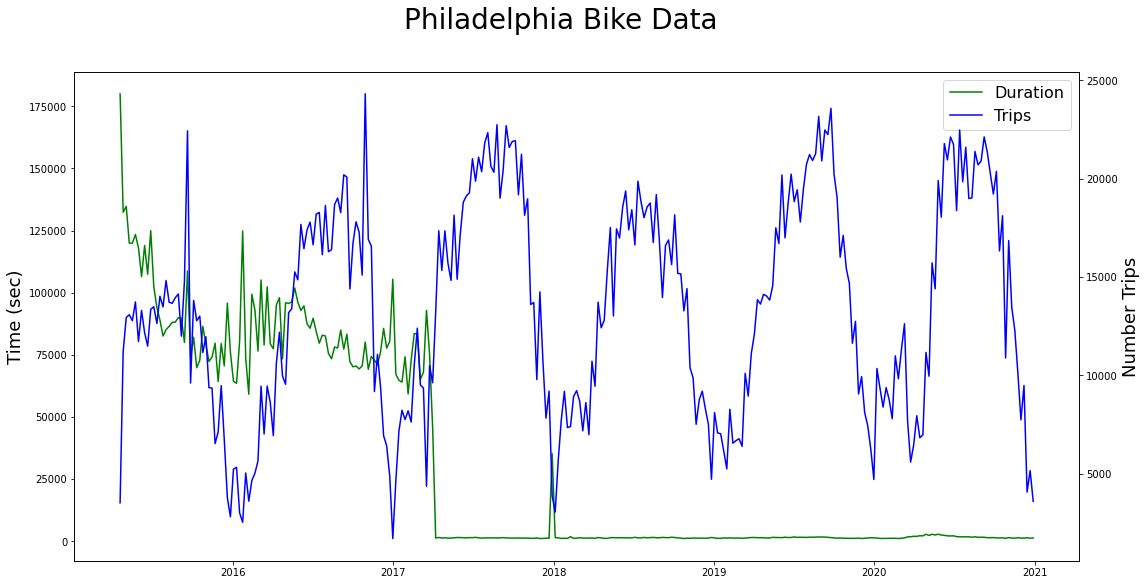

In [171]:
plotCityData(df_Philly)

## Pittsburgh Data

In [184]:
df_Pitts = dataCompile('Pittsburgh')
df_Pitts

,City,Year,Week,Average Duration (sec),Number Trips
0,Pittsburgh,2015,22,3796.410417,480
1,Pittsburgh,2015,23,3596.609366,1687
2,Pittsburgh,2015,24,3506.760044,1817
3,Pittsburgh,2015,25,3432.955188,2053
4,Pittsburgh,2015,26,2930.558482,2582
...,...,...,...,...,...
289,Pittsburgh,2020,49,3182.350538,465
290,Pittsburgh,2020,50,3363.065811,623
291,Pittsburgh,2020,51,3424.764505,293
292,Pittsburgh,2020,52,4125.935606,264


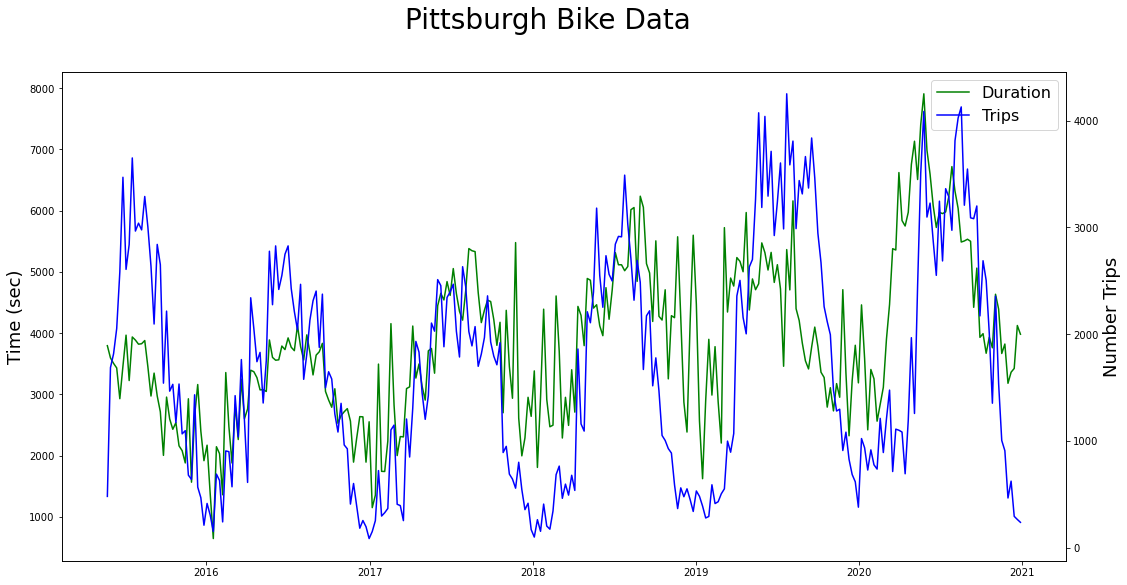

In [185]:
plotCityData(df_Pitts)

## Portland Data

In [234]:
df_Portland = dataCompile('Portland')
df_Portland

,City,Year,Week,Average Duration (sec),Number Trips
0,Portland,2016,29,1811.206127,11881
1,Portland,2016,30,1743.966662,14158
2,Portland,2016,31,1668.270571,12773
3,Portland,2016,32,1777.768638,11670
4,Portland,2016,33,1758.466403,11385
...,...,...,...,...,...
211,Portland,2020,32,1938.736706,3103
212,Portland,2020,33,2042.315399,2695
213,Portland,2020,34,1810.456961,2823
214,Portland,2020,35,1892.067119,2801


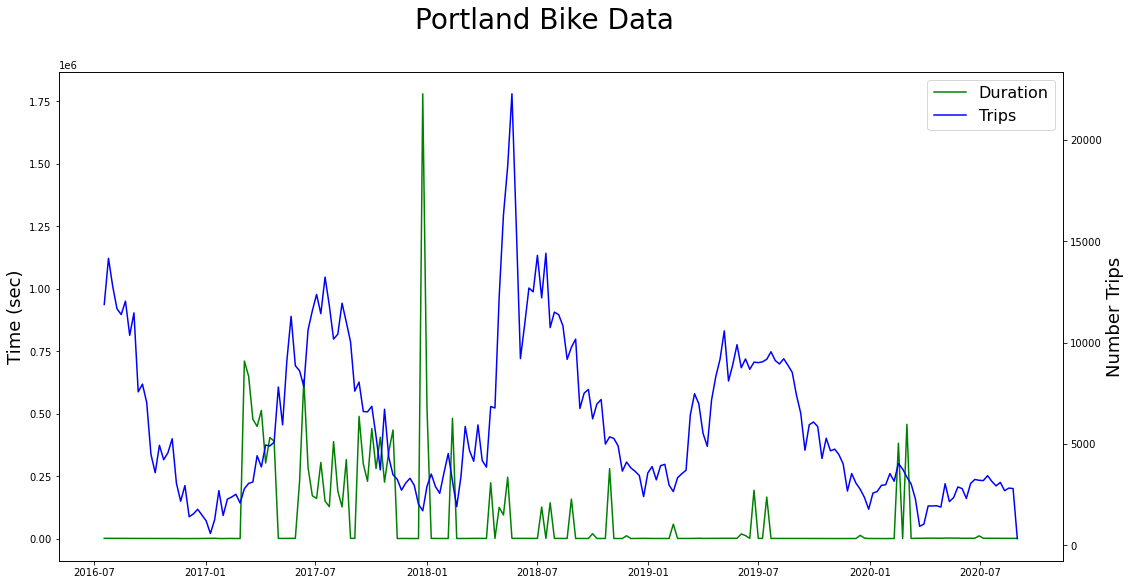

In [235]:
plotCityData(df_Portland)

## Washington Data

In [ ]:
df_Washington = dataCompile('Washington')
df_Washington

2010-capitalbikeshare-tripdata.csv
2011-capitalbikeshare-tripdata.csv
2012Q1-capitalbikeshare-tripdata.csv
2012Q2-capitalbikeshare-tripdata.csv
2012Q3-capitalbikeshare-tripdata.csv
2012Q4-capitalbikeshare-tripdata.csv
2013Q1-capitalbikeshare-tripdata.csv
2013Q2-capitalbikeshare-tripdata.csv
2013Q3-capitalbikeshare-tripdata.csv
2013Q4-capitalbikeshare-tripdata.csv
2014Q1-capitalbikeshare-tripdata.csv
2014Q2-capitalbikeshare-tripdata.csv
2014Q3-capitalbikeshare-tripdata.csv
2014Q4-capitalbikeshare-tripdata.csv
2015Q1-capitalbikeshare-tripdata.csv
2015Q2-capitalbikeshare-tripdata.csv
2015Q3-capitalbikeshare-tripdata.csv
2015Q4-capitalbikeshare-tripdata.csv
2016Q1-capitalbikeshare-tripdata.csv
2016Q2-capitalbikeshare-tripdata.csv
2016Q3-capitalbikeshare-tripdata.csv
2016Q4-capitalbikeshare-tripdata.csv
2017Q1-capitalbikeshare-tripdata.csv
2017Q2-capitalbikeshare-tripdata.csv
2017Q3-capitalbikeshare-tripdata.csv
2017Q4-capitalbikeshare-tripdata.csv
201801_capitalbikeshare_tripdata.csv
20180

In [ ]:
plotCityData(df_Washington)